#  Similarity search, distance estimation and moving average maladies:
Reference link:
http://www.cs.unm.edu/~mueen/FastestSimilaritySearch.html

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from numpy.fft import fft, ifft
from scipy.signal import convolve, correlate

# $x$: Base sequence
# $y$: Sequence you are searching for

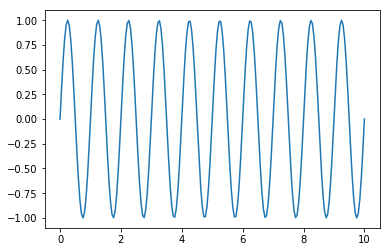

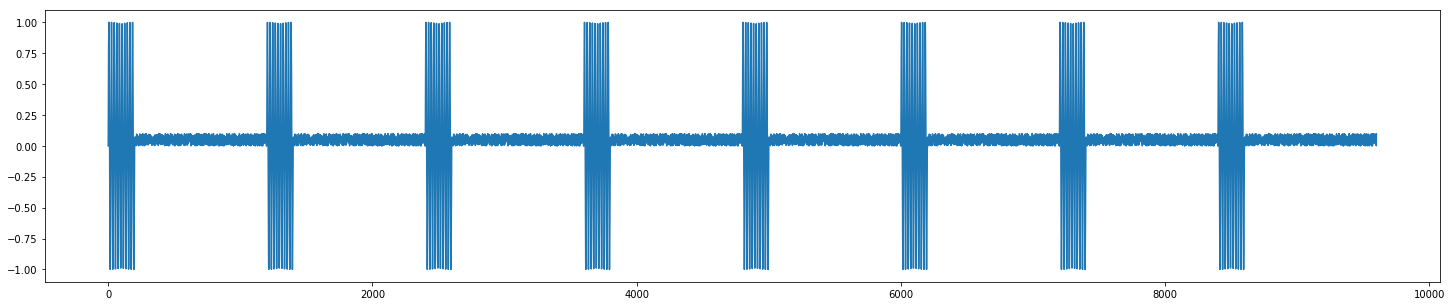

In [3]:
t=np.linspace(0,10,200)
y=np.sin(2*np.pi*t)
plt.plot(t,y)
x=np.append(y,np.random.rand(1000)*0.1)
for i in range(3):
    x=np.append(x,x)
plt.figure()
plt.figure(figsize=(25,5))
plt.plot(x)

# Distance vector estimations require you to compute moving averages fast. In MATLAB, we have movmean. 
### Numpy lacks this function. So, we explore 3 candidate moving average functions:Brute-Force (BF), Pandas based and a faster one that uses uniform_filter1d from scipy.ndimage.filters

In [4]:
from scipy.ndimage.filters import uniform_filter1d
def movmean_bf(x,m):
    n=len(x)
    movmean=np.zeros(n)
    for i in range(n):
        last_m_indices=range(i,-1,-1)[0:m+1]
        movmean[i]=np.mean(x[last_m_indices])
    return movmean
def movmean_pd(A,m):
    return pd.Series(A).rolling(window=m+1,min_periods=0).mean().values

def movmean_fast(A,m):
    orig=np.int(m/2)   
    movmean=uniform_filter1d(A.astype(float), m+1, mode='constant', origin=orig)
    movmean[0:m]=np.cumsum(A[0:m])/(np.arange(1,m+1)+0.0)
    return movmean


# Let's try the MATLAB example and confirm that we get the exact same results:
```
A = np.array([4, 8, 6, -1, -2, -3, -1, 3, 4, 5])
M = movmean(A,[2 0])
 4.0000    6.0000    6.0000    4.3333    1.0000   -2.0000   -2.0000   -0.3333    2.0000    4.0000
```
https://www.mathworks.com/help/matlab/ref/movmean.html



In [5]:
A = np.array([4, 8, 6, -1, -2, -3, -1, 3, 4, 5])
m=2
m1=movmean_bf(A,m)  
m2=movmean_fast(A,m)
m3=movmean_pd(A,m)
print(m1,m2,m3)

(array([ 4.        ,  6.        ,  6.        ,  4.33333333,  1.        ,
       -2.        , -2.        , -0.33333333,  2.        ,  4.        ]), array([ 4.        ,  6.        ,  6.        ,  4.33333333,  1.        ,
       -2.        , -2.        , -0.33333333,  2.        ,  4.        ]), array([ 4.        ,  6.        ,  6.        ,  4.33333333,  1.        ,
       -2.        , -2.        , -0.33333333,  2.        ,  4.        ]))


## Cool... now some stress tests and speed benchmarking

The max abs deviation-1 was 7.77156117238e-16
The max abs deviation-2 was 8.881784197e-16


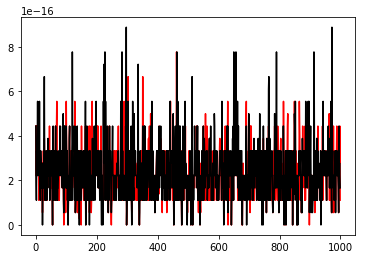

In [6]:
n_trials=1000
er1=[]
er2=[]
for i in range(n_trials):
    n=np.random.randint(3,108)
    A=np.random.rand(n)
    m=np.random.randint(2,n)
    
    m1=movmean_bf(A,m)  
    m2=movmean_fast(A,m)
    m3=movmean_pd(A,m)
    
    e1=np.abs(m1-m2)
    er1.append(np.max(e1))
    e2=np.abs(m1-m3)
    er2.append(np.max(e2))

        
print('The max abs deviation-1 was '+str(np.max(er1)))
print('The max abs deviation-2 was '+str(np.max(er2)))
plt.plot(er1,'r')
plt.plot(er2,'k')

In [7]:
n=1000
m=200
A=np.random.rand(n)
%timeit movmean_bf(A,m)
%timeit movmean_fast(A,m)
%timeit movmean_pd(A,m)

100 loops, best of 3: 16.4 ms per loop
The slowest run took 4.79 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 15.6 µs per loop
1000 loops, best of 3: 246 µs per loop


# Alright, now use this routine for distance estimation:

/m2/shared/env/local/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


10 loops, best of 3: 98.3 ms per loop
100 loops, best of 3: 2.01 ms per loop
1000 loops, best of 3: 1.67 ms per loop


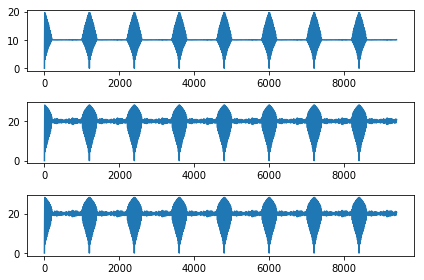

In [8]:
from scipy.spatial import distance
def dist_est_BF(x,y):
    m = len(y)
    n = len(x)
    dist=np.zeros(n-m)
    for i in range(0,n-m):
        dist[i] = distance.euclidean(x[i:i+m],y)
    return dist

def dist_est_fast1(x,y):
    #x is the data, y is the query
    m = len(y)
    n = len(x)

    # O(n) shit here!
    meany = np.mean(y);
    sigmay = np.std(y,ddof=0);

    meanx = pd.Series(x).rolling(window=m,min_periods=0).mean().values
    sigmax = pd.Series(x).rolling(window=m,min_periods=0).std(ddof=0).fillna(0).values
    
    y = y[::-1];#Reverse the query
    y = np.pad(y, (0, int(n - len(y)%n)), 'constant')

    #FFT: O(n log n) magic!
    X = fft(x);
    Y =  fft(y);
    Z = X*Y;
    z =  ifft(Z)
    
    dist = 2*(m-(z[m-1:n]-m*meanx[m-1:n]*meany)/(sigmax[m-1:n]*sigmay));
    return np.sqrt(dist)

def dist_est_fast2(x,y):
    #x is the data, y is the query
    m = len(y)
    n = len(x)

    # O(n) shit here!
    meany = np.mean(y);
    sigmay = np.std(y,ddof=0);
    # Running stats
    meanx = movmean_fast(x,m+1)
    sigmax = pd.Series(x).rolling(window=m,min_periods=0).std(ddof=0).fillna(0).values
    
    y = y[::-1];#Reverse the query
    y = np.pad(y, (0, int(n - len(y)%n)), 'constant')

    #FFT: O(n log n) magic!
    X = fft(x);
    Y = fft(y);
    Z = X*Y;
    z =  ifft(Z)
    
    dist = 2*(m-(z[m-1:n]-m*meanx[m-1:n]*meany)/(sigmax[m-1:n]*sigmay));
    return np.sqrt(dist)


d1=dist_est_BF(x,y)
d2=dist_est_fast1(x,y)
d3=dist_est_fast2(x,y)
plt.subplot(311)
plt.plot(d1)
plt.subplot(312)
plt.plot(d2)
plt.subplot(313)
plt.plot(d3)
plt.tight_layout()
#############
%timeit dist_est_BF(x,y)
%timeit dist_est_fast1(x,y)
%timeit dist_est_fast2(x,y)